<a href="https://colab.research.google.com/github/Ayazdani1997/stock-feature-prediction-final-pro/blob/master/Phase1_OCHLV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
!pip install pandas

In [42]:
import pandas
import matplotlib.pyplot as plt
from google.colab import drive
from os.path import join
import numpy

ROOT = '/content/drive'
drive.mount(ROOT)
HOME = join(ROOT,'My Drive')
COLAB_DIR = join(HOME, 'Colab Notebooks')
data = pandas.read_csv(join(COLAB_DIR, 'data.csv'), encoding='utf-16')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
data = data.drop(['Unnamed: 0', 'VAL', 'NUM_OF_TRANSACTIONS','CLOSE_ONE_DAY_BEFORE'], axis=1).rename(columns={'DTYYYYMMDD': 'DATE'})
data.head()

,TICKER,DATE,OPEN,HIGH,LOW,CLOSE,VOL
0,مظنه,20191120,0.0,1000000.0,0.0,1000000.0,0
1,مظنه,20191123,0.0,1000000.0,0.0,1000000.0,0
2,مظنه,20191124,0.0,1000000.0,0.0,1000000.0,0
3,مظنه,20191125,0.0,1000000.0,0.0,1000000.0,0
4,مظنه,20191126,0.0,1000000.0,0.0,1000000.0,0


In [44]:
mean_vol_per_ticker = data.groupby('TICKER')['VOL'].agg(numpy.mean).reset_index().sort_values('VOL', ascending=False)
mean_vol_per_ticker.head()

,TICKER,VOL
894,شاخص_قيمت(هم_وزن6),1.560700e+09
895,شاخص_قيمت6,1.559693e+09
898,شاخص_كل_(هم_وزن)6,1.559693e+09
889,شاخص_آزاد_شناور6,9.130124e+08
897,شاخص_كل6,8.711138e+08


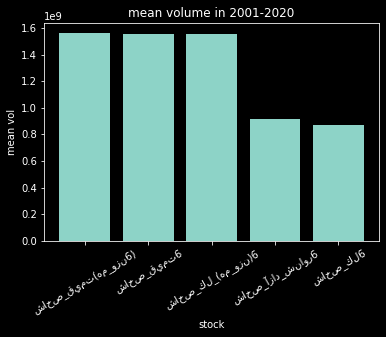

In [55]:
 plt.style.use('dark_background')
 five_first_stocks_with_mean_vol = mean_vol_per_ticker.head()
 index = numpy.arange(len(five_first_stocks_with_mean_vol['TICKER']))
 plt.bar(index, five_first_stocks_with_mean_vol['VOL'])
 plt.xlabel('stock', fontsize=10)
 plt.ylabel('mean vol', fontsize=10)
 plt.xticks(index, five_first_stocks_with_mean_vol['TICKER'], fontsize=10, rotation=30)
 plt.title('mean volume in 2001-2020')
 plt.show()

In [46]:
data_for_ticker_with_max_mean_vol = data[ data['TICKER'] == mean_vol_per_ticker.head().iloc[0]['TICKER'] ]
data_for_ticker_with_max_mean_vol.head()

,TICKER,DATE,OPEN,HIGH,LOW,CLOSE,VOL
3004878,شاخص_قيمت(هم_وزن6),20150224,9198.4,9181.8,9181.8,9181.8,278521094
3004879,شاخص_قيمت(هم_وزن6),20150225,9183.3,9109.1,9109.2,9109.1,271188153
3004880,شاخص_قيمت(هم_وزن6),20150228,9111.9,9090.0,9090.0,9090.0,257849083
3004881,شاخص_قيمت(هم_وزن6),20150301,9014.4,9030.4,9009.0,9030.4,475683577
3004882,شاخص_قيمت(هم_وزن6),20150302,9034.4,9043.5,9034.4,9043.5,717632564


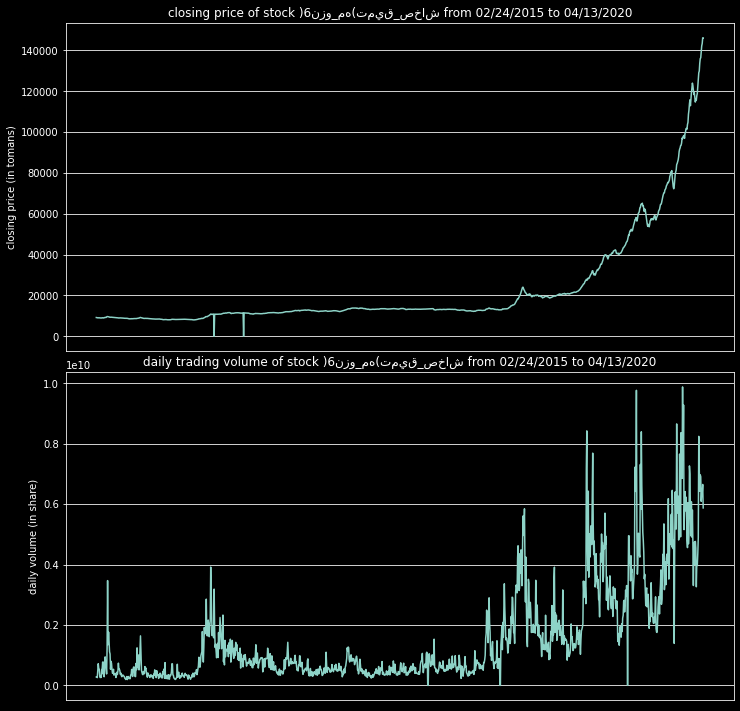

In [56]:
from datetime import datetime

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(10,10))
fig.tight_layout()

ax1 = axs[0]
ax2 = axs[1]
starting_date = str(data_for_ticker_with_max_mean_vol['DATE'].iloc[0])
ending_date = str(data_for_ticker_with_max_mean_vol['DATE'].iloc[len(data_for_ticker_with_max_mean_vol) - 1])
starting_date_object = datetime.strptime(starting_date,'%Y%m%d')
ending_date_object = datetime.strptime(ending_date,'%Y%m%d')
starting_date_in_new_format = starting_date_object.strftime('%m/%d/%Y')
ending_date_in_new_format = ending_date_object.strftime('%m/%d/%Y')

ax1.plot(data_for_ticker_with_max_mean_vol['CLOSE'])
ax1.set(ylabel='closing price (in tomans)')
ax1.set_title('closing price of stock ' + data_for_ticker_with_max_mean_vol['TICKER'].iloc[0][::-1] + 
          ' from ' + starting_date_in_new_format + ' to ' + ending_date_in_new_format)
# ax1.xticks([], labels=" ")
ax2.plot(data_for_ticker_with_max_mean_vol['VOL'])
ax2.set(ylabel='daily volume (in share)')
ax2.set_title('daily trading volume of stock ' + data_for_ticker_with_max_mean_vol['TICKER'].iloc[0][::-1] + 
          ' from ' + starting_date_in_new_format + ' to ' + ending_date_in_new_format)
plt.xticks([], labels="")
ax1.grid(True)
ax2.grid(True)
plt.show()

In [0]:
ten_stocks_with_max_trading_per_day = data.groupby('TICKER').agg({'DATE': ['min', 'max', 'count'], 'VOL': ['mean']}).reset_index().sort_values(('DATE', 'count'), ascending=False).head(10)
stock_with_max_trading_per_day = ten_stocks_with_max_trading_per_day['TICKER'].iloc[0]

In [0]:

window_in_days = 10
horizon_in_days = 1

def push_padding_to_dataframe_to_front(dataframe, window_in_days):
  for _ in range(window_in_days):
    row_to_insert = [0.0 for _ in dataframe.columns]
    row_to_insert[ len(row_to_insert) - 1 ] = 1.0
    dataframe.loc[-1] = row_to_insert
    dataframe.index = dataframe.index + 1
    dataframe = dataframe.sort_index()
    dataframe = dataframe.reset_index(drop=True)
  return dataframe


def normalize_dataframe(dataframe):
    normalized_df=(dataframe-dataframe.mean())/dataframe.std()
    return normalized_df


def generate_datasets_for_model(original_dataset, stocks_required):
  datasets = []
  label_sets = []
  for stock in stocks_required:  
    data_related_to_ith_max_trading_stock = original_dataset[ original_dataset['TICKER' ] == stock ]
    
    data_related_to_ith_max_trading_stock = data_related_to_ith_max_trading_stock.drop(['DATE' ,'TICKER'],1)

    data_related_to_ith_max_trading_stock = push_padding_to_dataframe_to_front(data_related_to_ith_max_trading_stock , window_in_days)


    _data_set = []
    _label_set = []

    new_col = numpy.where(data_related_to_ith_max_trading_stock['CLOSE'] >= data_related_to_ith_max_trading_stock['CLOSE'].shift(1), 1, 0) 

    normalized_data_related_to_ith_max = normalize_dataframe(data_related_to_ith_max_trading_stock)  

    for j in range(window_in_days, len(normalized_data_related_to_ith_max)):
      _data_set.append( numpy.array(normalized_data_related_to_ith_max[ j - window_in_days : j ].copy()) )
      
      _label_set.append( new_col )

    datasets.append(numpy.array(_data_set))
    label_sets.append(_label_set)
  return datasets, label_sets


In [0]:


training_sets, training_label_sets = generate_datasets_for_model(data, 
                                                                 list(ten_stocks_with_max_trading_per_day['TICKER'][0 : len(ten_stocks_with_max_trading_per_day) // 2 - 1])
                                                                 )


validation_sets, validation_label_sets = generate_datasets_for_model(data, [list(ten_stocks_with_max_trading_per_day['TICKER'])[len(ten_stocks_with_max_trading_per_day) // 2]])


test_sets, test_label_sets = generate_datasets_for_model(data, [list(ten_stocks_with_max_trading_per_day['TICKER'])[len(ten_stocks_with_max_trading_per_day) // 2 + 1]])